# Results Analysis

In [2]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-e7n1cnox
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-e7n1cnox
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.2 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torchinfo
import segmentation_models_pytorch as smp
from transformers import get_linear_schedule_with_warmup

In [4]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Test Set

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip
  inflating: img.npy                 
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip
  inflating: label.npy               
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip
  inflating: size.npy                


In [7]:
test_img = np.load('img.npy')
print(test_img.shape)

test_label = np.load('label.npy')
print(test_label.shape)

test_size = np.load('size.npy')
print(test_size.shape)

(7390, 256, 256, 3)
(7390, 256, 256)
(7390, 2)


In [8]:
test_label[test_label==1] = 0
test_label[test_label==2] = 1
test_label[test_label==3] = 2

np.unique(test_label)

array([0, 1, 2], dtype=uint8)

In [9]:
test_mask = np.ones_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  test_mask[i,0:test_size[i,0],0:test_size[i,1]] = 1

In [10]:
class Finetune_set(Dataset):
  
  def __init__(self, img, label, mask, size):
    super().__init__()
    self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.label = torch.Tensor(label).float() 
    self.mask = torch.Tensor(mask).float()
    self.size = torch.Tensor(size).float()

  def __len__(self):
    return len(self.img)

  def __getitem__(self,idx):
    return self.img[idx], self.label[idx], self.mask[idx], self.size[idx]

In [11]:
np.random.seed(42)

ids = list(range(test_img.shape[0]))
np.random.shuffle(ids)

# 40% labelled data, 60% unlabelled data
labelled_ids = ids[:int(0.4*test_img.shape[0])]
unlabelled_ids = ids[int(0.4*test_img.shape[0]):]

# 80% training, 5% validation, 15% test
train_ids = labelled_ids[:int(0.8*len(labelled_ids))]
valid_ids = labelled_ids[int(0.8*len(labelled_ids)):int(0.85*len(labelled_ids))]
test_ids = labelled_ids[int(0.85*len(labelled_ids)):]

# test set
test_set = Finetune_set(test_img[test_ids], test_label[test_ids], test_mask[test_ids], test_size[test_ids])
print(len(test_set))

# test set data loader
test_loader = DataLoader(test_set, shuffle=False, batch_size=64, num_workers=2)

444


## Inference and Evaluation

In [12]:
def inference(image, label, mask, size, model, device):

    concated = torch.concat([image, mask.unsqueeze(0)], dim=0).to(device)

    input = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(concated.unsqueeze(0))
    
    trimap = torch.argmax(output.squeeze().detach().cpu().permute(1,2,0), dim=2)
    if size[1] == 256:
      trimap[int(size[0]):, :] = 1
    else:
      trimap[:, int(size[1]):] = 1
  
    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,3))
    ax[0].imshow(image.permute(1,2,0).cpu())
    ax[1].imshow(label.cpu())
    ax[2].imshow(trimap)
    plt.show()

In [13]:
from sklearn.metrics import jaccard_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

def calculate_batch_metrics(y_true_batch, y_pred_batch):
    '''
    input: label_batch, output_batch
    output: iou, precision, recall, f1_score
    '''
    batch_size = y_true_batch.shape[0]
    batch_metrics = []

    for i in range(batch_size):
        y_true = y_true_batch[i].flatten()
        y_pred = y_pred_batch[i].flatten()

        iou = jaccard_score(y_true, y_pred, average="weighted")
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        sample_metrics = [iou, precision, recall, f1_score]
        batch_metrics.append(sample_metrics)

    return np.array(batch_metrics)

baseline loaded


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


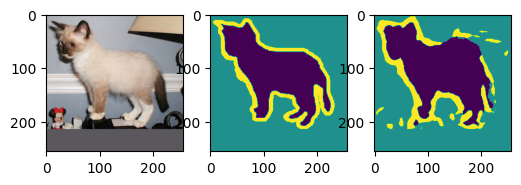

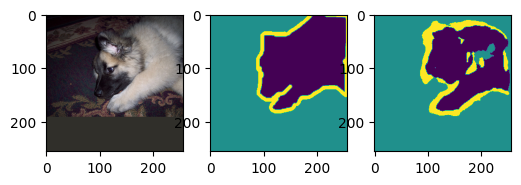



----------------------------------------
model: baseline, mean iou: 0.7818, precision: 0.8817, recall: 0.8599, f1-score: 0.8625
----------------------------------------


semi-supervised loaded


100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


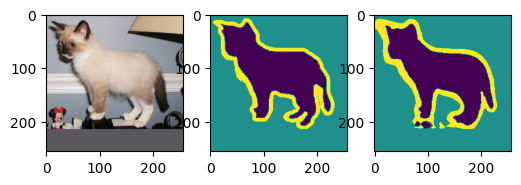

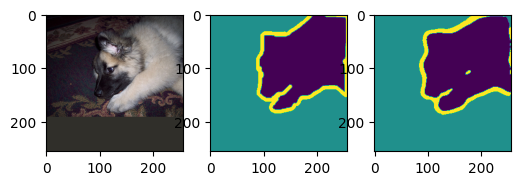



----------------------------------------
model: semi-supervised, mean iou: 0.9007, precision: 0.9457, recall: 0.9424, f1-score: 0.9423
----------------------------------------


upper_bound loaded


100%|██████████| 7/7 [00:18<00:00,  2.67s/it]


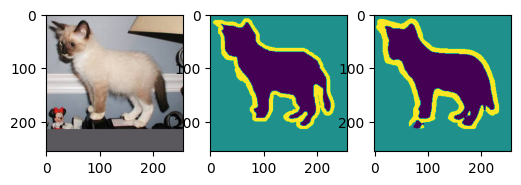

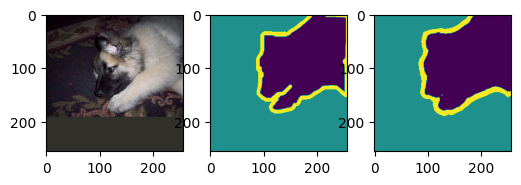



----------------------------------------
model: upper_bound, mean iou: 0.9080, precision: 0.9506, recall: 0.9467, f1-score: 0.9470
----------------------------------------


semi-10% loaded


100%|██████████| 7/7 [00:19<00:00,  2.76s/it]


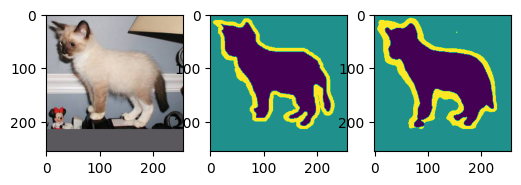

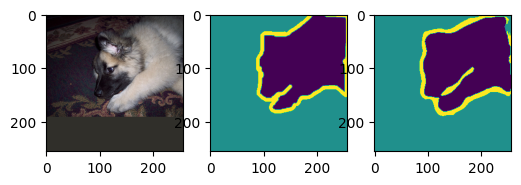



----------------------------------------
model: semi-10%, mean iou: 0.8844, precision: 0.9376, recall: 0.9313, f1-score: 0.9321
----------------------------------------


semi-20% loaded


100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


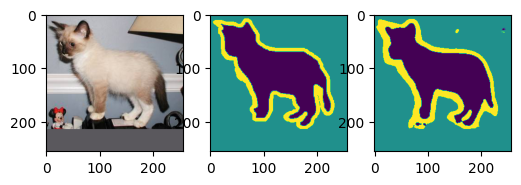

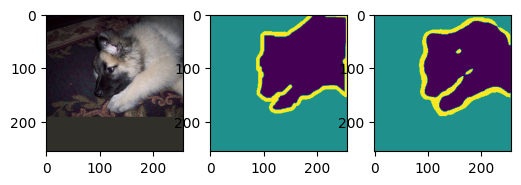



----------------------------------------
model: semi-20%, mean iou: 0.8903, precision: 0.9411, recall: 0.9346, f1-score: 0.9359
----------------------------------------


semi-30% loaded


100%|██████████| 7/7 [00:18<00:00,  2.71s/it]


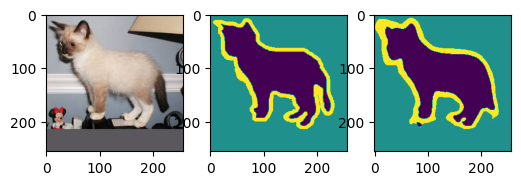

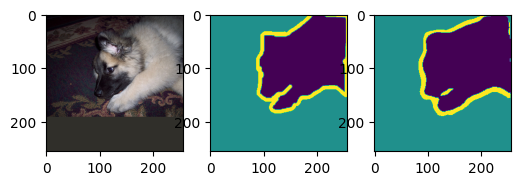



----------------------------------------
model: semi-30%, mean iou: 0.8941, precision: 0.9429, recall: 0.9375, f1-score: 0.9381
----------------------------------------


semi-40% loaded


100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


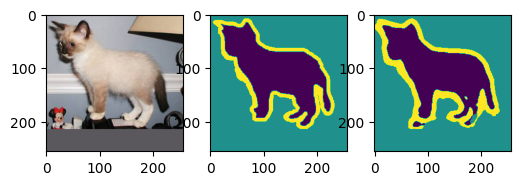

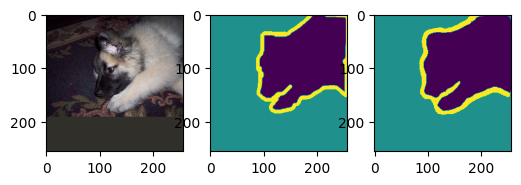



----------------------------------------
model: semi-40%, mean iou: 0.8993, precision: 0.9457, recall: 0.9409, f1-score: 0.9414
----------------------------------------




In [14]:
model_names = ['baseline', 'semi-supervised', 'upper_bound', 'semi-10%', 'semi-20%', 'semi-30%', 'semi-40%']
ckpt_names = ['jieming_base', 'jieming_semi_supervised', 'jieming_upperbound', 'TC_semi_supervised_portion=0.1', 
              'TC_semi_supervised_portion=0.2', 'TC_semi_supervised_portion=0.3', 'TC_semi_supervised_portion=0.4']

res = []

for ckpt_name, model_name in zip(ckpt_names, model_names):

    model = smp.Unet(
        encoder_name="resnet34",         # use ResNet34 as backbone
        encoder_weights=None,            # use randomly initialized weights
        encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
        decoder_use_batchnorm=True,      # if True, BatchNorm2d layer between Conv2D and Activation layers is used
        decoder_attention_type=None,     # attention module used in decoder (default=None)
        in_channels=4,                   # number of input channels, 1 additional attention mask (default=3, expects RGB images)
        activation=None,                 # activation function to apply after the final convolution layer (default=None)
        classes=3,                       # output 3 channels for trimaps
        aux_params=None,                 # parameters of the auxiliary output (defualt=None)
    )

    ckpt = torch.load(f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/{ckpt_name}.pth')
    model.encoder.load_state_dict(ckpt['encoder'])
    model.decoder.load_state_dict(ckpt['decoder'])
    model.segmentation_head.load_state_dict(ckpt['mask'])
    model.to(device)
    print(f"{model_name} loaded")
    del ckpt

    metrics = [[0,0,0,0]]
    for X in tqdm(test_loader):
        img, label_batch, mask, size_batch = X[0].to(device), X[1].long(), X[2].to(device), X[3]
        concated = torch.concat([img, mask.unsqueeze(1)], dim=1)
        model.eval()
        with torch.no_grad():
            output = model(concated)
        trimap_batch = torch.argmax(output.squeeze().detach().cpu().permute(0, 2, 3, 1), dim=3)
        for i in range(len(trimap_batch)):
            trimap = trimap_batch[i]
            size = size_batch[i]
            if size[1] == 256:
                trimap[int(size[0]):, :] = 1
            else:
                trimap[:, int(size[1]):] = 1
        batch_metrics = calculate_batch_metrics(label_batch, trimap_batch)
        metrics = np.concatenate((metrics, batch_metrics), axis = 0)
    
    inference(img[0], label_batch[0], mask[0], size_batch[0], model, device)
    inference(img[1], label_batch[1], mask[1], size_batch[1], model, device)

    mask_metrics = np.mean(metrics[1:], axis = 0)
    print("\n")
    print(40*'-')
    print(f"model: {model_name}, mean iou: {mask_metrics[0]:.4f}, precision: {mask_metrics[1]:.4f}, recall: {mask_metrics[2]:.4f}, f1-score: {mask_metrics[3]:.4f}")
    print(40*'-')
    print("\n")
    res.append(mask_metrics)

    del model
    torch.cuda.empty_cache()

np.save('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/res.npy', np.array(res))

In [ ]:
# # baseline, semi-supervised, upper bound
# base_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/jieming_base.pth')
# semi_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/jieming_semi_supervised.pth')
# upper_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/jieming_upperbound.pth')

# # open question
# semi_10_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/TC_semi_supervised_portion=0.1.pth')
# semi_20_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/TC_semi_supervised_portion=0.2.pth')
# semi_30_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/TC_semi_supervised_portion=0.3.pth')
# semi_40_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/Result Analysis/TC_semi_supervised_portion=0.4.pth')

# Test Results

In [32]:
from tabulate import tabulate

headers = ['Model', 'Mean IoU', 'Precision', 'Recall', 'F1-Score']

data = []

for i in range(len(res)):

    data.append([model_names[i], 
                 res[i][0],
                 res[i][1],
                 res[i][2],
                 res[i][3],])

print(tabulate(data, headers=headers, tablefmt='orgtbl', stralign="center", numalign="right", floatfmt=".4f"))

|      Model      |   Mean IoU |   Precision |   Recall |   F1-Score |
|-----------------+------------+-------------+----------+------------|
|    baseline     |     0.7818 |      0.8817 |   0.8599 |     0.8625 |
| semi-supervised |     0.9007 |      0.9457 |   0.9424 |     0.9423 |
|   upper_bound   |     0.9080 |      0.9506 |   0.9467 |     0.9470 |
|    semi-10%     |     0.8844 |      0.9376 |   0.9313 |     0.9321 |
|    semi-20%     |     0.8903 |      0.9411 |   0.9346 |     0.9359 |
|    semi-30%     |     0.8941 |      0.9429 |   0.9375 |     0.9381 |
|    semi-40%     |     0.8993 |      0.9457 |   0.9409 |     0.9414 |
